# The Blue Paint Incident

You have received an anonymous tip that something 'irregular' is happening with your purchases of blue paint. Your inital meeting with the purchase manager reveals the following:
* Your company has five vendors that deliver **blue paint** (Material ID: BLUEPAINT).
* Each vendor has a long-running contract with a standard delivery volume of **100** liters per shipment
* The **delivery tolerance** acceptable for good receipt of shipment of blue paint is +/- 5 percent.

You have requested a copy of the data from the SAP system. You focus on the `goods receipt` events of your purchasing processes. You have received two tables:
* `MKPF` contains the header information of the material documents.
* `MSEG` contains the line item information of the material documents.

Analyze the data to understand the irregularity. 

## Setup

Some initialization to make life easier. **Make sure to run the following cell before proceeding.**

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import matplotlib.pyplot as plt
%matplotlib inline

[Pandas](https://pandas.pydata.org) is the most important workhorse in data analytics.
[Seaborn](https://seaborn.pydata.org) is a visualization library.

In [2]:
import pandas as pd
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.0f' % x)

You have received two tables from the SAP system that contain all the information of the `goods receipt` step:
2. The header information is stored in the table `MKPF`.
1. The line items are stored in the table `MSEG`.

In [3]:
mkpf_table = pd.read_csv('https://raw.githubusercontent.com/mschermann/forensic_accounting/master/MKPF.csv')
mseg_table = pd.read_csv('https://raw.githubusercontent.com/mschermann/forensic_accounting/master/MSEG.csv')

Both tables from with huge numbers of columns.

In [4]:
mkpf_table.columns
mseg_table.columns

Index(['MANDT', 'MBLNR', 'MJAHR', 'VGART', 'BLART', 'BLAUM', 'BLDAT', 'BUDAT',
       'CPUDT', 'CPUTM', 'AEDAT', 'USNAM', 'TCODE', 'XBLNR', 'BKTXT', 'FRATH',
       'FRBNR', 'WEVER', 'XABLN', 'AWSYS', 'BLA2D', 'TCODE2', 'BFWMS', 'EXNUM',
       'SPE_BUDAT_UHR', 'SPE_BUDAT_ZONE', 'LE_VBELN', 'SPE_LOGSYS',
       'SPE_MDNUM_EWM', 'GTS_CUSREF_NO', 'FLS_RSTO', 'MSR_ACTIVE', 'KNUMV'],
      dtype='object')

Index(['MANDT', 'MBLNR', 'MJAHR', 'ZEILE', 'LINE_ID', 'PARENT_ID',
       'LINE_DEPTH', 'MAA_URZEI', 'BWART', 'XAUTO',
       ...
       'FSH_UMSEA', 'FSH_UMCOLL', 'FSH_UMTHEME', 'SGT_CHINT', 'OINAVNW',
       'OICONDCOD', 'CONDI', 'WRF_CHARSTC1', 'WRF_CHARSTC2', 'WRF_CHARSTC3'],
      dtype='object', length=209)

You can find the definition of all the columns in the SAP system using the transaction code `SE16`.

## Understanding the Data

### The MKPF table

For our purposes, we use the following columns from `MKPF`:
* `MBLNR` - Contains the material document number.
* `USNAM` - Contains the inventory employee who posted the material document.

**Your task:** Reduce the MKPF table on the two columns. Store the result in a variable called `mkpf`.

In [5]:
mkpf = mkpf_table.loc[:, ['MBLNR', 'USNAM']]

**Your task:** Show the first five rows of the MKPF table.

In [6]:
mkpf.head()

,MBLNR,USNAM
0,5000000010,GBI-085
1,5000000011,GBI-085
2,5000000012,GBI-085
3,5000000013,GBI-085
4,5000000014,GBI-085


### The MSEG table

For our purposes, we use the following columns from `MSEG`:
* `MBLNR` - Contains the material document number.
* `BWART` - Contains the movement type of the line item.
* `MATNR` - Contains the material id.
* `LIFNR` - Contains the vendor id.
* `MENGE` - Contains the volume of the shipment. 

**Your task:** Reduce the MSEG table on the columns of interest. Store the result in a variable called `mseg`.

In [7]:
mseg = mseg_table.loc[:, ['MBLNR','BWART', 'MATNR','LIFNR','MENGE']]

**Your task:** Show the unique movement types in the `MSEG`.

In [8]:
mseg['BWART'].unique()

array([101, 122, 161, 261])

The following list shows important movement types:
* 101 - Goods receipt for a purchase order
* 102 - Goods receipt for a purchase order - reversal
* 122 - Return delivery to vendor
* 161 - Return delivery to vendor for a purchase order
* 261 - Consumption for production order from warehouse.

**Your task:** Filter the MSEG table on the movement type of interest. Store the result in a variable called `mseg`.

In [9]:
mseg = mseg[mseg['BWART']==101]

Additionally, we are only interested in the goods movements of blue paint.

**Your task:** Filter the `MSEG` table on the material id of blue paint. Store the result in a variable called `mseg`.

In [10]:
mseg = mseg[mseg['MATNR']=='BLUEPAINT']

**Your task:** Assign the variable type `int` to the column that contains the shipment volume.

In [11]:
mseg['MENGE'] = mseg.MENGE.astype(int)

**Make sure to run the following cell before proceeding.**

In [12]:
mseg.reset_index(inplace=True, drop=True)

**Your task:** Show a sample of the filtered `MSEG` table.

In [13]:
mseg.sample(10)

,MBLNR,BWART,MATNR,LIFNR,MENGE
81,5000000450,101,BLUEPAINT,125000,103
150,5000000519,101,BLUEPAINT,125134,95
36,5000000374,101,BLUEPAINT,125109,100
121,5000000490,101,BLUEPAINT,125098,100
8,5000000197,101,BLUEPAINT,125134,103
37,5000000375,101,BLUEPAINT,125109,95
62,5000000400,101,BLUEPAINT,125000,104
69,5000000432,101,BLUEPAINT,125000,100
83,5000000452,101,BLUEPAINT,125109,104
135,5000000504,101,BLUEPAINT,125109,103


## Analysis of blue paint shipments

**Your task**: Calculate the mean, the minimum value, and the maximum value of the received shipments.

In [22]:
mseg[['MENGE', 'LIFNR']].describe()

,MENGE,LIFNR
count,162,162
mean,100,125091
std,3,45
min,95,125000
25%,98,125098
50%,100,125109
75%,103,125110
max,105,125134


In [15]:
mseg.MENGE.mean()
mseg.MENGE.min()
mseg.MENGE.max()

100.24074074074075

95

105

**Your task**: Plot the volume of the shipments in relationship to the index (`mseg.index`).

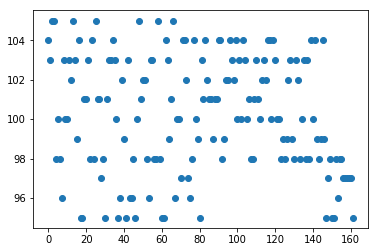

In [16]:
plt.scatter(mseg.index, mseg.MENGE)

**Your task**: Confirm that five vendors deliver blue paint.

In [17]:
mseg.LIFNR.unique()

array([125000, 125134, 125109, 125098, 125110])

We normalize the number of shipments per vendor. **Make sure to run the following cell before proceeding.**

In [18]:
mseg['order'] = mseg.groupby('LIFNR').cumcount()

**Your task**: Develop a chart that shows the shipment volumes across time. To do this, replace the `<PLACEHOLDER>` in the code below.

In [19]:
g = sns.FacetGrid(mseg, col='<VENDOR>', col_wrap=3);
g.map(plt.plot, 'order', '<VOLUME OF SHIPMENT>');

for a in g.axes:
    a.axhline('<CONTRACTED VOLUME>', alpha=0.5, color='grey');

KeyError: '<VENDOR>'

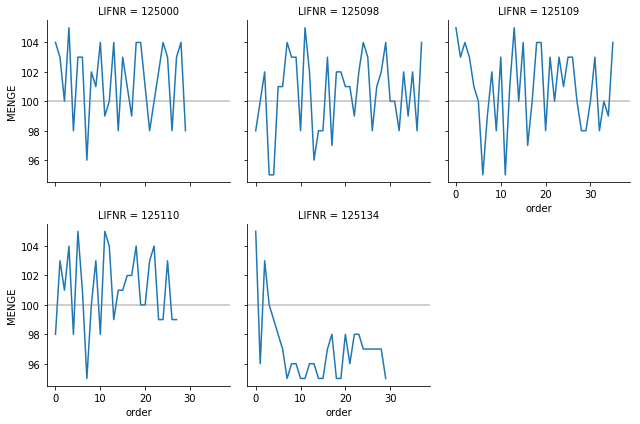

In [19]:
g = sns.FacetGrid(mseg, col='LIFNR', col_wrap=3)
g.map(plt.plot, "order", "MENGE")

for a in g.axes:
    a.axhline(100, alpha=0.5, color='grey')

## Identify the person of interest in the inventory

**Your task**: Left-Join the `MSEG` and `MKPF` tables. Store the result in a variable called `inventory`.

In [20]:
inventory = pd.merge(mseg, mkpf, on='MBLNR', how='left')

**Your task**: Group the `inventory` by the vendor id and show the unique id's of the inventory employees that managed shipments from each vendor.

In [21]:
inventory.groupby('LIFNR')['USNAM'].unique()

LIFNR
125000    [GBIFAC-01, GBI-018, GBI-034, GBI-053, GBI-054...
125098    [GBI-013, GBI-018, GBI-012, GBI-008, GBI-044, ...
125109    [GBIFAC-01, GBI-018, GBI-054, GBI-034, GBI-008...
125110    [GBI-018, GBI-008, GBI-038, GBI-012, GBI-045, ...
125134                                          [GBIFAC-01]
Name: USNAM, dtype: object

**Who is the person of interest?**